In [1]:
import tensorflow as tf
from PIL import Image
import os
import zipfile
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [37]:
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip  #for only 10 percent train data

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip #For all Data

--2024-03-15 09:15:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  41.5MB/s    in 13s     

2024-03-15 09:15:16 (39.2 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [38]:
# file path ====> /content/drive/MyDrive/spectogram.zip
zip_folder = zipfile.ZipFile("/content/10_food_classes_all_data.zip","r")
zip_folder.extractall()
zip_folder.close()

In [39]:
from tensorflow.keras import layers

test_dir = '/content/10_food_classes_all_data/test'
train_dir = '/content/10_food_classes_all_data/train'


train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 batch_size = 32,
                                                                 image_size = (224,224),
                                                                 label_mode = "categorical",
                                                                 shuffle = True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 batch_size = 32,
                                                                 image_size = (224,224),
                                                                 label_mode = "categorical",
                                                                 shuffle = True)



data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(20),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
])

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [40]:
# Creating Frozen Base Model
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Creating Transfer learning Model
inputs = layers.Input(shape = (224,224,3))
x = data_augmentation(inputs)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(10,activation = 'softmax')(x)

model_1 = tf.keras.Model(inputs,output)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = 'accuracy')

In [41]:
# Creating Checkpoint callback for model

checkpoint_path = '/content/10_food_classes_checkpoint/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only = True,
                                                         save_best_only = False,
                                                         save_freq = 'epoch')


history_1 = model_1.fit(train_data,
            epochs = 5,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            validation_steps = (0.25 * len(test_data)),
            callbacks = checkpoint_callback)

Epoch 1/5
235/235 [==============================] - 90s 351ms/step - loss: 1.0640 - accuracy: 0.6895 - val_loss: 0.4762 - val_accuracy: 0.8813
Epoch 2/5
235/235 [==============================] - 70s 297ms/step - loss: 0.6723 - accuracy: 0.7920 - val_loss: 0.3931 - val_accuracy: 0.8844
Epoch 3/5
235/235 [==============================] - 67s 283ms/step - loss: 0.6034 - accuracy: 0.8071 - val_loss: 0.3556 - val_accuracy: 0.8969
Epoch 4/5
235/235 [==============================] - 64s 270ms/step - loss: 0.5481 - accuracy: 0.8291 - val_loss: 0.3459 - val_accuracy: 0.8906
Epoch 5/5
235/235 [==============================] - 56s 238ms/step - loss: 0.5307 - accuracy: 0.8308 - val_loss: 0.3301 - val_accuracy: 0.9000


In [42]:
model_1.layers

In [43]:
for layer in model_1.layers:
  print(layer.trainable)

True
True
False
True
True


### Finally Fine-Tuning Our Model

In [44]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

for layer in model_1.layers:
  print(layer.trainable)

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = 'accuracy')

True
True
True
True
True


In [45]:
model_1.load_weights(checkpoint_path)

history_2 = model_1.fit(train_data,
            epochs = 10,
            steps_per_epoch = len(train_data),
            validation_data = test_data,
            initial_epoch = history_1.epoch[-1],
            validation_steps = 0.25 * len(test_data),
            callbacks = [checkpoint_callback])

Epoch 5/10
235/235 [==============================] - 64s 234ms/step - loss: 0.8197 - accuracy: 0.7511 - val_loss: 0.3609 - val_accuracy: 0.8813
Epoch 6/10
235/235 [==============================] - 52s 222ms/step - loss: 0.5139 - accuracy: 0.8352 - val_loss: 0.3084 - val_accuracy: 0.9031
Epoch 7/10
235/235 [==============================] - 46s 194ms/step - loss: 0.4243 - accuracy: 0.8589 - val_loss: 0.2612 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 49s 208ms/step - loss: 0.3485 - accuracy: 0.8796 - val_loss: 0.3228 - val_accuracy: 0.8875
Epoch 9/10
235/235 [==============================] - 47s 197ms/step - loss: 0.3065 - accuracy: 0.8989 - val_loss: 0.2352 - val_accuracy: 0.9203
Epoch 10/10
235/235 [==============================] - 44s 184ms/step - loss: 0.2707 - accuracy: 0.9083 - val_loss: 0.2466 - val_accuracy: 0.9141


<Axes: >

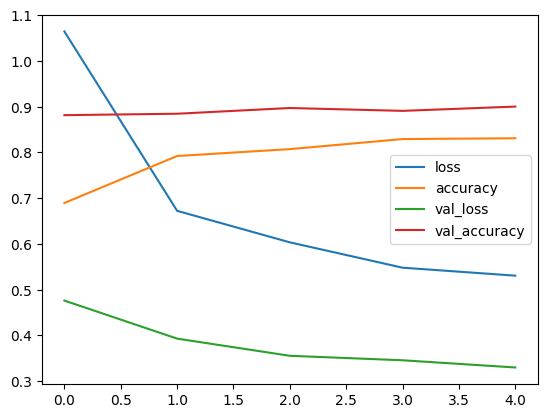

In [46]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

<Axes: >

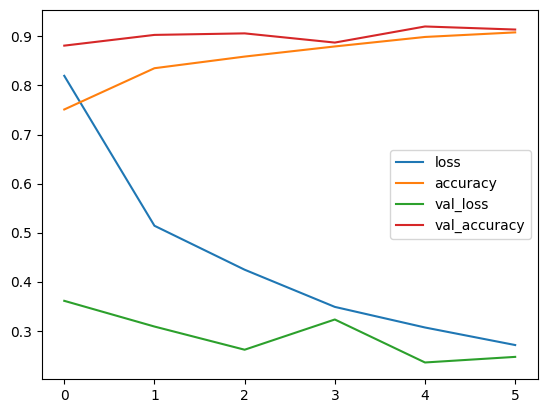

In [47]:
pd.DataFrame(history_2.history).plot()

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-25]:
  layer.trainable = False

model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(lr = 0.0001),
                metrics = 'accuracy')

history_3 = model_1.fit(train_data,
                        epochs = 15,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = 0.50*(len(test_data)),
                        initial_epoch = history_2.epoch[-1],
                        callbacks = [checkpoint_callback])

Epoch 10/15


<Axes: >

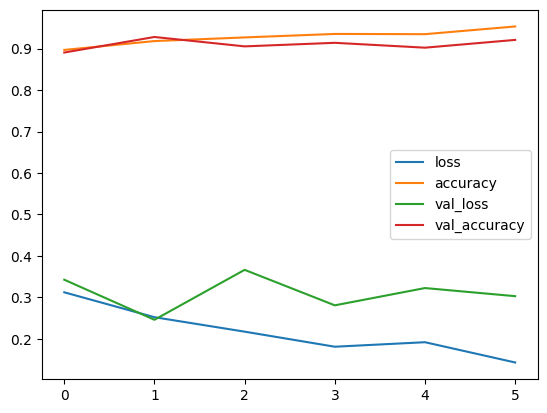

In [ ]:
pd.DataFrame(history_3.history).plot()